In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import pickle, gzip
import gc
import time

In [2]:
train_series = pd.read_csv('training_set.csv')
metadata_train = pd.read_csv('training_set_metadata.csv')

simple_features = train_series.groupby(
    ['object_id', 'passband'])['flux'].agg(
    ['mean', 'median', 'max', 'min', 'std']).unstack('passband')


#construct time series using binned observations:
ts_mod = train_series[['object_id', 'mjd', 'passband', 'flux']].copy()
#bin by 5 days, reducing the size of data but still giving a time series
ts_mod['mjd_d5'] = (ts_mod['mjd'] / 5).astype(int)
ts_mod = ts_mod.groupby(['object_id', 'mjd_d5', 'passband'])['flux'].mean().reset_index()

#pivotting
ts_piv = pd.pivot_table(ts_mod, 
                        index='object_id', 
                        columns=['mjd_d5', 'passband'], 
                        values=['flux'],
                        dropna=False)

gc.enable()

In [3]:
del metadata_train['ra'],metadata_train['decl'],metadata_train['gal_l'], metadata_train['gal_b'],metadata_train['hostgal_photoz'],metadata_train['hostgal_photoz_err'], metadata_train['distmod'], metadata_train['mwebv']
#Bin into ddf and non-ddf training
ddf = metadata_train[(metadata_train['ddf'] == 1)]
del ddf['ddf']

ddf_far_away= (ddf[(ddf['hostgal_specz'] > 0)])
ddf_far_away.set_index('object_id', inplace=True)
ddf_nearby= ddf[(ddf['hostgal_specz'] <=0)]
ddf_nearby.set_index('object_id', inplace=True)
non_ddf = metadata_train[(metadata_train['ddf'] == 0)]
del non_ddf['ddf']

non_ddf_far_away= non_ddf[(non_ddf['hostgal_specz'] >0)]
non_ddf_far_away.set_index('object_id', inplace=True)
non_ddf_nearby= non_ddf[(non_ddf['hostgal_specz'] <=0 )]
non_ddf_nearby.set_index('object_id', inplace=True)
del ddf, non_ddf, ddf_far_away['hostgal_specz'], non_ddf_far_away['hostgal_specz'], ddf_nearby['hostgal_specz'], non_ddf_nearby['hostgal_specz']

gc.collect()

bins = [ddf_far_away, ddf_nearby, non_ddf_far_away, non_ddf_nearby]

In [129]:
def get_data_point(object_id, bin_name):
    x = torch.tensor(ts_piv.loc[object_id].values.reshape(-1, 1, 6), dtype = torch.float32)
    x[x != x] = 0
    y = torch.tensor([classes.index(bin_name.loc[object_id].target)])
    return x, y

def random_data_point(bin_name):
    object_id = bin_name.sample().index.values[0]
    return get_data_point(object_id, bin_name)

In [5]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size=1):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_size
        self.batch_size = batch_size
        #TODO add dropout or something
        self.lstm = nn.LSTM(input_size, hidden_size) #,dropout=.2, num_layers=2)
        self.hidden2out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden = self.init_hidden()
    
    def forward(self, sequence):
        x = sequence.view(len(sequence), self.batch_size , -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        output  = self.hidden2out(lstm_out[-1])
        output = self.softmax(output)
        return output

    def init_hidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_dim),
                torch.zeros(1, self.batch_size, self.hidden_dim))

In [7]:
classes = tuple(metadata_train.target.unique())
vc = non_ddf_far_away.target.value_counts(normalize=True)
weights = torch.tensor([1 - vc.loc[i] if i in vc.index else 0 for i in classes])
weights

tensor([0.0000, 0.9364, 0.7748, 0.6260, 0.0000, 0.0000, 0.9640, 0.9661, 0.9101,
        0.8766, 0.9714, 0.0000, 0.9747, 0.0000])

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return classes[category_i], category_i

In [156]:
def train(bin_name, epochs=1, verbose=True):
    # Calculate weights of each class to balance
    vc = bin_name.target.value_counts(normalize=True)
    weights = torch.tensor([1/(vc.loc[i])**3 if i in vc.index else 1 for i in classes])
    
    # Initialize Model
    model = RNN(6, 32, 14)
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.05, nesterov=True, momentum=0.01)
    
    print_every = 500
    current_loss = 0
    accuracy = []
    
    start_t = time.time()
    
    for epoch in range(epochs):
        randomized_bin = up_sample(bin_name)
        n = len(randomized_bin)
        for i, row in randomized_bin.iterrows():
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of light curve inputs.
            obj_id = row['object_id']
            x_train, y_train = get_data_point(obj_id, bin_name)

            # Step 3. Run our forward pass.
            y_hat = model(x_train)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = criterion(y_hat, y_train)
            current_loss += loss
            loss.backward()
            optimizer.step()

            if (i+1 % print_every == 0 and verbose):
                print("Epoch {} {:.0f}% ===> Avg Loss: {:.3f}".format(epoch+1, (i/n*100), current_loss/print_every))
                current_loss=0
        print('Training', end = ' ')
        y_hat, _ = predict(model, bin_name)
        acc = len(y_hat[y_hat["y_pred"]==y_hat['y_true']])/n
        accuracy.append(acc)
        print("Accuracy over upsampled: {:.2f}".format(acc))
    print("Finished")
    return model, accuracy

In [151]:
def predict(model, bin_name, sample=1):
    labels = []
    right = 0
    s = bin_name.sample(frac=sample)
    with torch.no_grad():
        for obj_id in s.index:
            x, y = get_data_point(obj_id, s)
            y_hat = model(x)
            label = categoryFromOutput(y_hat)[0]
            labels.append([obj_id, label, bin_name.loc[obj_id].target])
            if classes[y]==label:
                right += 1
    accuracy = right/len(s)
    print(f"Accuracy: {right/len(s)*100}")
    labels= pd.DataFrame(labels, columns=["object_id", "y_pred", "y_true"])
    labels.set_index("object_id", inplace=True)
    return labels, accuracy

In [ ]:
model = train(ddf_nearby, epochs=10)

Accuracy: 33.14814814814815


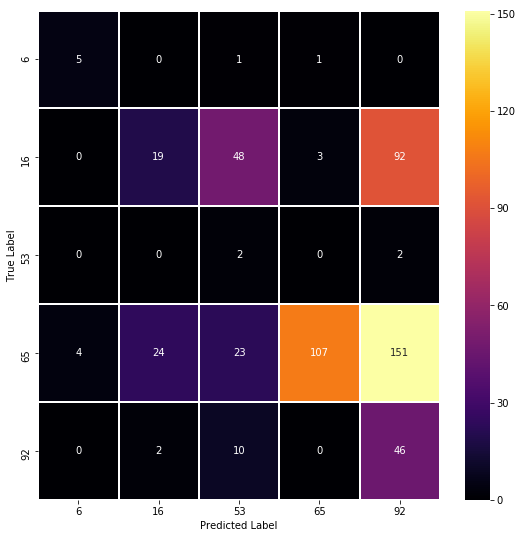

In [159]:
y_hat2,_ = predict(model, ddf_nearby)
confusion(y_hat2)

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import warnings

In [77]:
def confusion(labels, plot=True):
    classes = np.sort(list(labels.y_true.unique()))
    y_pred = np.array(labels.y_pred)
    y_true = np.array(labels.y_true)
    cm=confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(9,9))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, cmap='inferno', annot=True, lw=1, fmt="d")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    if plot:
        plt.show()

def plot_accuracy(bin_name, accuracy):
    fig_nodes = plt.figure(figsize=(8,8))
    ax1 = fig_nodes.add_subplot(1,1,1)
    ax1.plot(accuracy, marker='o', markersize=5)
    ax1.set_ylim([0,1])
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(f"Training Accuracy wrt Epochs")
    plt.show()

In [140]:
def up_sample(bin_name):
    from sklearn.utils import resample
    classes = bin_name.target.unique()
    class_dfs = [bin_name[bin_name.target == class_] for class_ in classes]
    n = np.max([len(df) for df in class_dfs])
    even_dfs = [resample(df,
                        replace=True,
                        n_samples=n) for df in class_dfs]
    return pd.concat(even_dfs).sample(frac=1).reset_index()

In [142]:
test = up_sample(ddf_far_away)
test.head()

,object_id,target
0,63860,42
1,139362,64
2,237006,88
3,232478,52
4,136931,52


In [145]:
ddf_far_away.head()

,target
object_id,
713,88
730,42
745,90
1124,90
1598,90
